# <font color = 'indianred'> **1. Setting up the Environment** </font>



In [ ]:
from pathlib import Path
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount("/content/drive")
    !pip install transformers evaluate wandb datasets accelerate -U -qq
    basepath = '/content/drive/MyDrive/NLP/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# standard data science librraies for data handling and v isualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import random
from sklearn.model_selection import train_test_split
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import PreTrainedModel, PretrainedConfig
from transformers import TrainingArguments, Trainer
from datasets import Dataset
import evaluate
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import joblib
import torch
import torch.nn as nn

# New libraries introduced in this notebook
import evaluate
from datasets import load_dataset, DatasetDict
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import AutoConfig
from transformers import pipeline
import wandb
from google.colab import userdata
from huggingface_hub import login

In [ ]:
wandb_api_key = userdata.get('WANDB_API_KEY')
hf_token = userdata.get('HF_TOKEN')

In [ ]:
if hf_token:
    # Log in to Hugging Face
    login(token=hf_token)
    print("Successfully logged in to Hugging Face!")
else:
    print("Hugging Face token not found in notebook secrets.")


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful
Successfully logged in to Hugging Face!


In [ ]:
if wandb_api_key:
  wandb.login(key=wandb_api_key)
  print("Successfully logged in to WANDB!")
else:
    print("WANDB key not found in notebook secrets.")


wandb: Currently logged in as: muvvanagajyothi (muvvanagajyothi-the-university-of-texas-at-dallas). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Successfully logged in to WANDB!


In [ ]:
base_folder = Path(basepath)
data_folder = base_folder/'Data Folder'
model_folder = base_folder/'Models'
custom_functions = base_folder/'custom-functions'

# <font color = 'indianred'> **2. Load Data set**
    


In [ ]:
train_df = pd.read_csv(data_folder/'train.csv')

In [ ]:
import re
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Remove special characters and numbers
    text = re.sub(r'\W+|\d+', ' ', text)
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Convert to lowercase
    text = text.lower()
    return text

In [ ]:
train_df

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7719,2018-01993,@BadHombreNPS @SecretaryPerry If this didn't m...,1,0,1,0,0,0,0,0,0,0,0
7720,2018-01784,Excited to watch #stateoforigin tonight! Come ...,0,0,0,0,1,0,1,0,0,0,0
7721,2018-04047,"Blah blah blah Kyrie, IT, etc. @CJC9BOSS leavi...",1,0,1,0,0,0,0,0,1,0,0
7722,2018-03041,#ThingsIveLearned The wise #shepherd never tru...,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
train_df['Tweet'] = train_df['Tweet'].apply(preprocess_text)

# <font color = 'indianred'> **3. Accessing and Manuplating Splits**</font>



In [ ]:
train_data,valid_data= train_test_split(train_df, test_size=0.2, random_state=42)
X_train= train_data['Tweet']
y_train= train_data[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']].values.tolist()
X_valid= valid_data['Tweet']
y_valid= valid_data[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']].values.tolist()

trainset = Dataset.from_dict({
    'text': X_train,  # Convert Series to list
    'labels': y_train         # Your multilabels for training
})

validset = Dataset.from_dict({
    'text': X_valid,  # Convert Series to list
    'labels': y_valid          # Your multilabels for validation
})

# Print the dataset sizes
print("Training dataset size:", len(trainset))
print("Validation dataset size:", len(validset))

Training dataset size: 6179
Validation dataset size: 1545


In [ ]:
train_val_set= DatasetDict(
    {"train": trainset, "valid": validset})

In [ ]:
train_val_set

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 6179
    })
    valid: Dataset({
        features: ['text', 'labels'],
        num_rows: 1545
    })
})

In [ ]:
train_val_set['train']['labels'][0]

[0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0]

In [ ]:
train_val_set['train']['text'][0]

'going to get myself a copy of s cujo for an upcoming project that i can t talk about just yet'

In [ ]:
train_val_set['valid']['labels'][0]

[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1]

In [ ]:
train_val_set['valid']['text'][0]

'i m due for a big change i ve prayed on it i think i deserve it'

# <font color = 'indianred'>**4. Load pre-trained Tokenizer**</font>



In [ ]:
checkpoint = "albert-base-v2"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

#<font color = 'indianred'> **5. Create function for Tokenizer**



In [ ]:
def tokenize_fn(batch):
    return tokenizer(text = batch["text"], truncation=True)

In [ ]:
tokenized_dataset= train_val_set.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(
    ['text']
)
tokenized_dataset.set_format(type='torch')

Map:   0%|          | 0/6179 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6179
    })
    valid: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1545
    })
})

In [ ]:
tokenized_dataset['train']['labels'][0]

tensor([0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0])

In [ ]:
import torch
tokenized_dataset = (tokenized_dataset
          .map(lambda x : {"float_label": x["labels"].to(torch.float)}, remove_columns=["labels"])
          .rename_column("float_label", "label"))

Map:   0%|          | 0/6179 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset['train']['label'][0:3]

tensor([[0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
        [1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.]])

In [ ]:
print(len(tokenized_dataset["train"]["input_ids"][2]))
print(len(tokenized_dataset["train"]["input_ids"][1]))

23
16


#  <font color = 'indianred'> **6. Model Training**

##  <font color = 'indianred'> **6.1 Download pre-trained model**

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 11, problem_type="multi_label_classification")  # We are using the same checkpiont as we have used for tokenizer

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##  <font color = 'indianred'> **6.2 Downaload and Modify Model Config File**

In [ ]:
class_names = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
print("Class names:", class_names)
config = AutoConfig.from_pretrained(checkpoint)
id2label= {id_: label_ for id_, label_ in enumerate(class_names)}
label2id = {label_: id_ for id_, label_ in enumerate(class_names)}
config.id2label = id2label
config.label2id = label2id
model.config = config


Class names: ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']


##  <font color = 'indianred'> **6.3 compute_metrics function** </font>



In [ ]:
# load training metrices
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    # accuracy_metric = evaluate.load('accuracy', 'multilabel')

    logits, labels = eval_pred
    preds = (logits > 0).astype(int)
    accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
    accuracy_all = accuracy.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy_label':accuracy_label['accuracy'],
             'accuracy_all':accuracy_all['accuracy']}


## <font color = 'indianred'> **6.4 Training Arguments**</font>







In [ ]:
# Define the directory where model checkpoints will be saved
model_folder = base_folder / "Models"/"Bert"
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)
run_name= 'tweet_emotion_exp2'

# Configure training parameters
training_args = TrainingArguments(
    seed=42,
    # Training-specific configurations
    num_train_epochs=3,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=8,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=8,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=2e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    eval_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=100,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=100,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=100,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= run_name,  # Experiment name for Weights & Biases
)


##  <font color = 'indianred'> **6.5 Initialize Trainer**</font>



In [ ]:
def calculate_pos_weights(dataset):
    # Initialize counters for all labels
    num_labels = len(dataset['train']['label'][0])
    total_positives = [0] * num_labels
    total_negatives = [0] * num_labels

    # Count positives and negatives for each label
    for label_array in dataset['train']['label']:
        for i, label in enumerate(label_array):
            if label == 1:
                total_positives[i] += 1
            else:
                total_negatives[i] += 1

    # Calculate pos_weight for each label
    pos_weight = [total_negatives[i] / max(total_positives[i], 1) for i in range(num_labels)]
    return torch.tensor(pos_weight)

In [ ]:
pos_weights = calculate_pos_weights(tokenized_dataset)

In [ ]:
pos_weights

tensor([ 1.7018,  6.0216,  1.6576,  4.8403,  1.6657,  8.0734,  2.3256,  7.7274,
         2.4082, 17.9540, 19.0617])

In [ ]:
# initialize trainer
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels").float()  # Ensure labels are float for BCE loss
        outputs = model(**inputs)
        logits = outputs.get("logits")

        device = next(model.parameters()).device

        loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weights.to(device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)


<ipython-input-50-0411a216a7fe>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## <font color = 'indianred'> **6.6 Setup WandB**</font>

In [ ]:
%env WANDB_PROJECT = tweet_emotion_albert_base_v2_exp3

env: WANDB_PROJECT=tweet_emotion_albert_base_v2_exp3


##  <font color = 'indianred'> **6.7 Training and Validation**

In [ ]:
trainer.train()  # start training

Step,Training Loss,Validation Loss,F1 Micro,F1 Macro,Accuracy Label,Accuracy All
100,0.508000,0.457792,0.001636,0.001572,0.784525,0.023301
200,0.435300,0.430699,0.378825,0.177322,0.805296,0.097087
300,0.391700,0.401105,0.470992,0.239164,0.827773,0.150809
400,0.390400,0.396650,0.514901,0.286202,0.827596,0.168285
500,0.387900,0.386366,0.505180,0.274523,0.837011,0.161812
600,0.381400,0.382112,0.512014,0.312124,0.837482,0.166343
700,0.375000,0.380101,0.560064,0.348392,0.838600,0.179288
800,0.362100,0.373903,0.571154,0.346782,0.842542,0.191586
900,0.333500,0.368835,0.563745,0.366616,0.845366,0.194822
1000,0.339000,0.372119,0.570307,0.369580,0.845366,0.210356


TrainOutput(global_step=2319, training_loss=0.3461615139680363, metrics={'train_runtime': 2514.7082, 'train_samples_per_second': 7.371, 'train_steps_per_second': 0.922, 'total_flos': 25811095042458.0, 'train_loss': 0.3461615139680363, 'epoch': 3.0})

In [ ]:
eval_results = trainer.evaluate(tokenized_dataset["valid"])

In [ ]:
eval_results

{'eval_loss': 0.3537118434906006,
 'eval_f1_micro': 0.6110673183036418,
 'eval_f1_macro': 0.4312765648473675,
 'eval_accuracy_label': 0.8548396587231538,
 'eval_accuracy_all': 0.22006472491909385,
 'eval_runtime': 42.5025,
 'eval_samples_per_second': 36.351,
 'eval_steps_per_second': 4.564,
 'epoch': 3.0}

In [ ]:
wandb.log({"eval_f1_macro": eval_results["eval_f1_macro"], "eval_loss": eval_results["eval_loss"], "eval_accuracy": eval_results["eval_accuracy_all"]})

<font color = 'indianred'> *Finetune threshold* </font>

In [ ]:
from scipy.special import expit as sigmoid
valid_output = trainer.predict(tokenized_dataset["valid"])

# Get probabilities from logits
valid_logits = valid_output.predictions
valid_probs = sigmoid(valid_logits)
valid_labels = np.array(valid_output.label_ids.astype(int))

In [ ]:
valid_logits.shape

(1545, 11)

In [ ]:
valid_probs.shape

(1545, 11)

In [ ]:
valid_labels.shape

(1545, 11)

In [ ]:
def find_best_thresholds_multilabel(probabilities, labels):
    """
    Find best threshold for each label that maximizes F1 score

    Args:
        probabilities: Array of shape (n_samples, n_labels) with predicted probabilities
        labels: Array of shape (n_samples, n_labels) with true binary labels

    Returns:
        thresholds: List of best thresholds for each label
        metrics: Dictionary containing best F1, precision, and recall for each label
    """
    n_labels = labels.shape[1]
    best_thresholds = []
    metrics = {}

    for label_idx in range(n_labels):
        # Get scores and labels for this label
        label_scores = probabilities[:, label_idx]
        label_true = labels[:, label_idx]

        # Sort by scores
        rows = list(zip(label_scores, label_true))
        rows = sorted(rows, key=lambda x: x[0], reverse=True)

        # Initialize metrics
        best_f1 = best_precision = best_recall = 0
        threshold = 0

        # Count total positives for this label
        total_positives = sum(label_true)

        # Initialize counters
        total_predicted_positives = 0
        true_positives = 0

        # print(f"\nAnalyzing label {label_idx}")

        # Try different thresholds
        for i in range(len(rows) - 1):
            score, label = rows[i]
            total_predicted_positives += 1
            if label == 1:
                true_positives += 1

            if true_positives > 0:
                precision = true_positives / total_predicted_positives
                recall = true_positives / total_positives
                f1 = 2 * precision * recall / (precision + recall)

                # Update best metrics if current F1 is better
                if f1 > best_f1:
                    best_f1 = f1
                    best_precision = precision
                    best_recall = recall
                    threshold = (rows[i][0] + rows[i + 1][0]) / 2

                    # print(f"New best threshold found: {threshold:.3f}")
                    # print(f"F1: {best_f1:.3f}, Precision: {best_precision:.3f}, Recall: {best_recall:.3f}")

        best_thresholds.append(threshold)
        metrics[label_idx] = {
            'f1': best_f1,
            'precision': best_precision,
            'recall': best_recall,
            'threshold': threshold
        }


    return best_thresholds, metrics



In [ ]:
optimal_thresholds, metrics = find_best_thresholds_multilabel(valid_probs, valid_labels)


In [ ]:
optimal_thresholds

[0.463051438331604,
 0.17612075805664062,
 0.29347896575927734,
 0.3110097646713257,
 0.2749142050743103,
 0.33377182483673096,
 0.46599024534225464,
 0.21596074104309082,
 0.3250117897987366,
 0.07938758283853531,
 0.13621672987937927]

In [ ]:
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')
def compute_metrics(eval_pred, thresholds):
    # accuracy_metric = evaluate.load('accuracy', 'multilabel')

    logits, labels = eval_pred
    probs = sigmoid(logits)
    preds = (probs > thresholds).astype(int)
    accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
    accuracy_all = accuracy.compute(predictions=preds, references=labels)
    f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_micro':f1_micro['f1'],
            'f1_macro':f1_macro['f1'],
            'accuracy_label':accuracy_label['accuracy'],
             'accuracy_all':accuracy_all['accuracy']}

In [ ]:
compute_metrics((valid_logits, valid_labels), optimal_thresholds)

{'f1_micro': 0.6132968127490039,
 'f1_macro': 0.5308031688182304,
 'accuracy_label': 0.8172403648131803,
 'accuracy_all': 0.14627831715210357}

<font color = 'indianred'> *Confusion Matrix*</font>

In [ ]:
valid_preds = (valid_probs > optimal_thresholds).astype(int)
mcm = multilabel_confusion_matrix(valid_labels, valid_preds)
print(mcm)

[[[ 823  150]
  [ 155  417]]

 [[1039  284]
  [ 105  117]]

 [[ 683  266]
  [ 120  476]]

 [[1176   64]
  [ 152  153]]

 [[ 780  206]
  [ 106  453]]

 [[1305   89]
  [  68   83]]

 [[ 967  145]
  [ 134  299]]

 [[1194  164]
  [  95   92]]

 [[ 834  251]
  [ 148  312]]

 [[1296  179]
  [  47   23]]

 [[1329  124]
  [  54   38]]]


In [ ]:
def multilabel_evaluation(y_true, y_pred, class_names=None, figsize=(12, 8)):
    """
    Generate comprehensive evaluation visualizations for multilabel classification results.

    Parameters:
    -----------
    y_true : array-like
        True labels (n_samples, n_classes)
    y_pred : array-like
        Predicted labels (n_samples, n_classes)
    class_names : list, optional
        List of class names for better visualization
    figsize : tuple, optional
        Base figure size for plots (width, height)

    Returns:
    --------
    dict
        Dictionary containing the computed metrics for each class
    """
    # Validate inputs
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # Generate class names if not provided
    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_true.shape[1])]

    # Calculate confusion matrices
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # 1. Individual Confusion Matrix Heatmaps
    n_classes = len(class_names)
    n_cols = min(3, n_classes)
    n_rows = (n_classes + n_cols - 1) // n_cols

    plt.figure(figsize=(figsize[0], figsize[1] * n_rows/2))
    for idx, matrix in enumerate(mcm):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                    xticklabels=['Pred Neg', 'Pred Pos'],
                    yticklabels=['True Neg', 'True Pos'])
        plt.title(f'{class_names[idx]}')
    plt.tight_layout()
    plt.show()

    # 2. Calculate and plot aggregate metrics
    metrics = {
        'Precision': precision_score(y_true, y_pred, average=None),
        'Recall': recall_score(y_true, y_pred, average=None),
        'F1-Score': f1_score(y_true, y_pred, average=None)
    }

    metrics_df = pd.DataFrame(metrics, index=class_names)

    # Metrics Heatmap
    plt.figure(figsize=(figsize[0]/1.5, figsize[1]/1.5))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='Blues')
    plt.title('Performance Metrics by Class')
    plt.tight_layout()
    plt.show()

    # 3. Metrics Histogram
    plt.figure(figsize=(figsize[0], figsize[1]/1.5))
    metrics_df.plot(kind='bar', width=0.8)
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score by Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4. Calculate and return summary statistics
    summary_stats = {
        'macro_avg': {
            'precision': np.mean(metrics['Precision']),
            'recall': np.mean(metrics['Recall']),
            'f1': np.mean(metrics['F1-Score'])
        },
        'per_class': metrics_df.to_dict()
    }

    return summary_stats


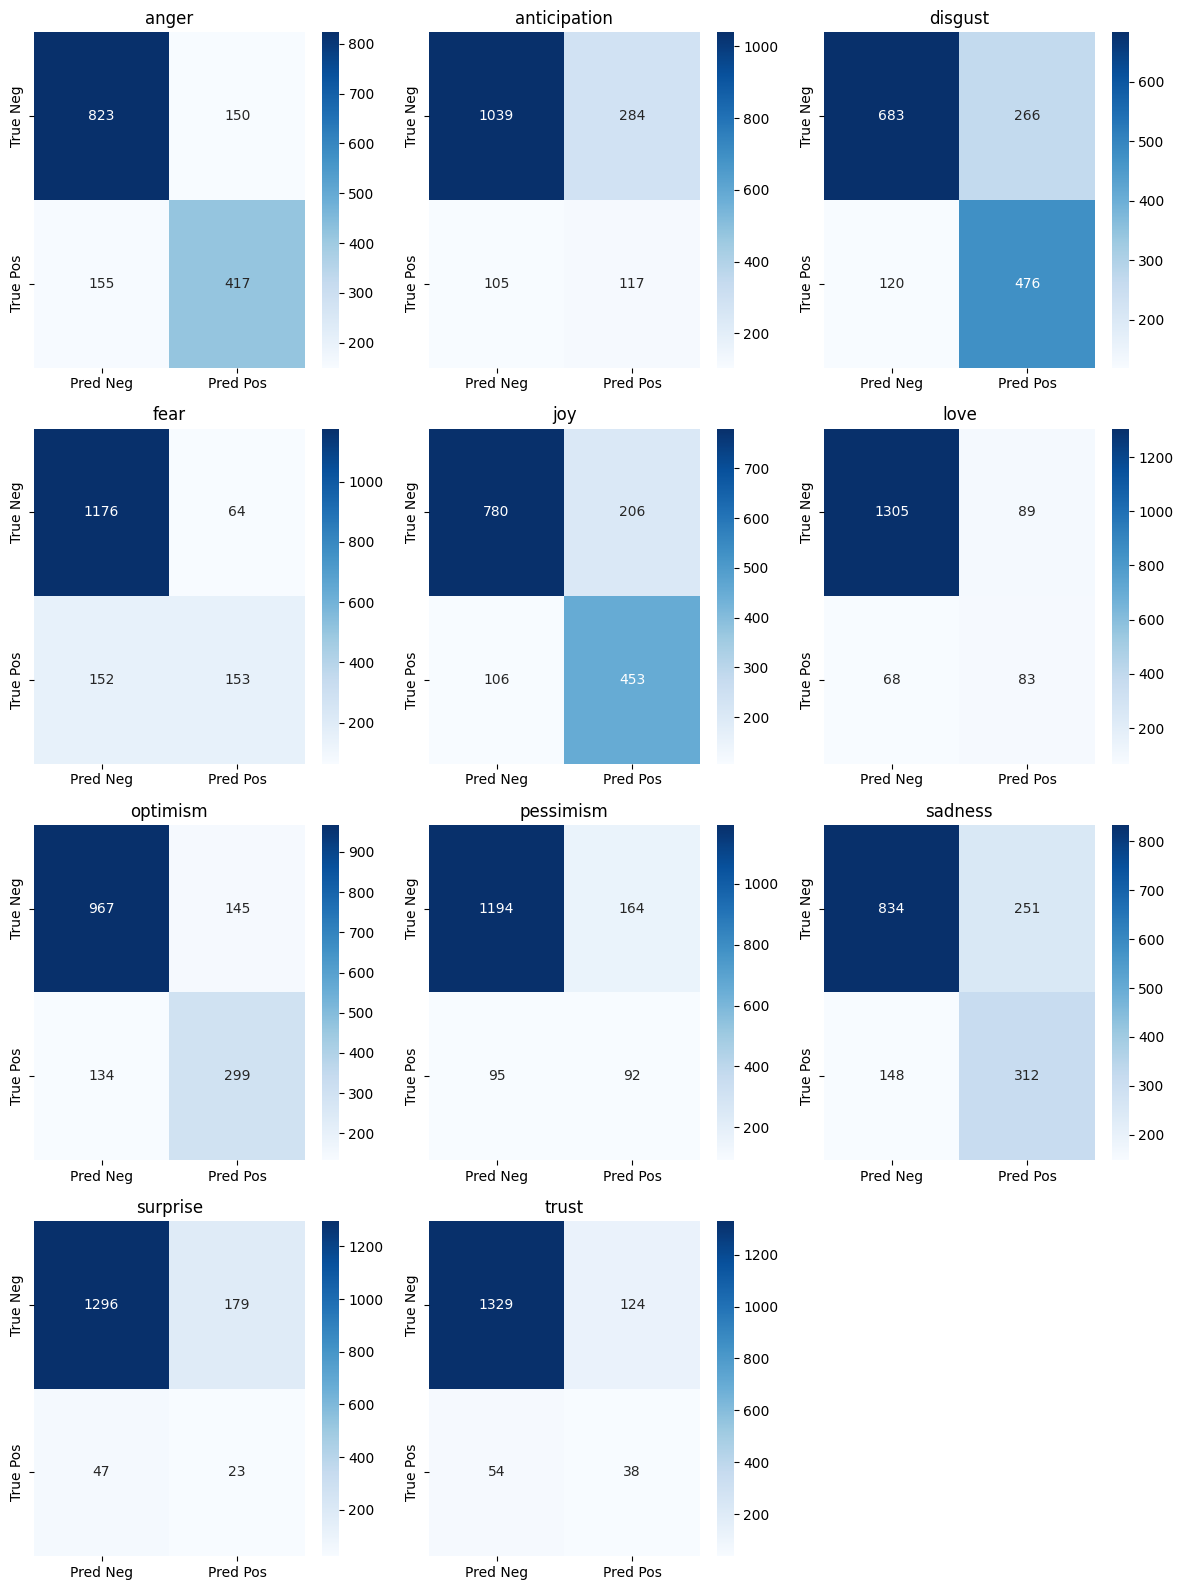

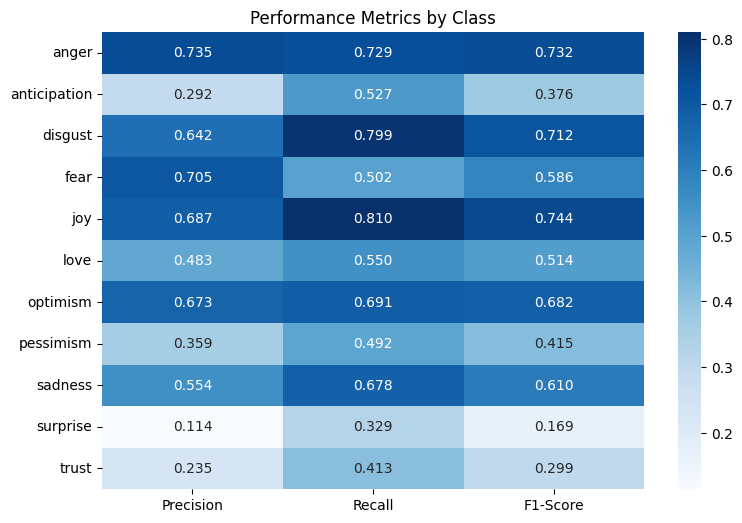

<Figure size 1200x533.333 with 0 Axes>

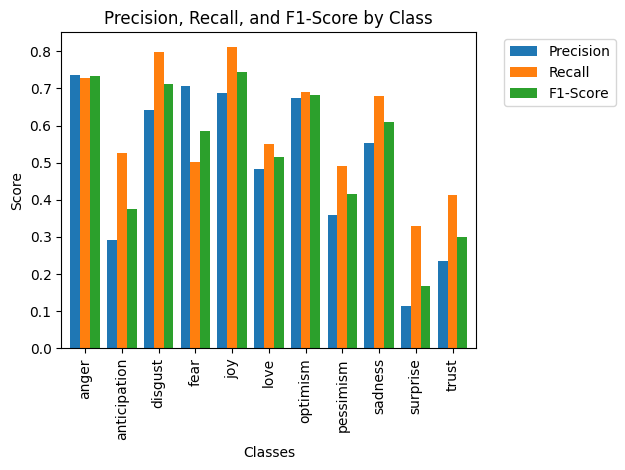

{'macro_avg': {'precision': 0.49810581314194696,
  'recall': 0.5926159252087602,
  'f1': 0.5308031688182304},
 'per_class': {'Precision': {'anger': 0.7354497354497355,
   'anticipation': 0.29177057356608477,
   'disgust': 0.6415094339622641,
   'fear': 0.7050691244239631,
   'joy': 0.6874051593323217,
   'love': 0.48255813953488375,
   'optimism': 0.6734234234234234,
   'pessimism': 0.359375,
   'sadness': 0.5541740674955595,
   'surprise': 0.11386138613861387,
   'trust': 0.2345679012345679},
  'Recall': {'anger': 0.7290209790209791,
   'anticipation': 0.527027027027027,
   'disgust': 0.7986577181208053,
   'fear': 0.5016393442622951,
   'joy': 0.8103756708407871,
   'love': 0.5496688741721855,
   'optimism': 0.6905311778290993,
   'pessimism': 0.4919786096256685,
   'sadness': 0.6782608695652174,
   'surprise': 0.32857142857142857,
   'trust': 0.41304347826086957},
  'F1-Score': {'anger': 0.7322212467076383,
   'anticipation': 0.3756019261637239,
   'disgust': 0.7115097159940209,
   

In [ ]:
multilabel_evaluation(y_true=valid_labels, y_pred=valid_preds, class_names=class_names, figsize=(12, 8))

<font color = 'indianred'> *Get best checkpoint*</font>


In [ ]:
# After training, let us check the best checkpoint
# We need this for Inference
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")


The best model was saved at step 2300.


#  <font color = 'indianred'> **7. Performance on Test Set and Model Inference** </font>




In [ ]:
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
custom_pipeline = pipeline(
    task="text-classification",
    model=checkpoint,
    tokenizer=checkpoint,
    device=-1,
    return_all_scores=True,
    function_to_apply='sigmoid')

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
test_data=pd.read_csv(data_folder/'test.csv')

In [ ]:
test_data['Tweet'] = test_data['Tweet'].apply(preprocess_text)

In [ ]:
test_data

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-01559,dont worry indian army is on its ways to dispa...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
1,2018-03739,academy of sciences eschews the normally sober...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
2,2018-00385,i blew that opportunity __,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
3,2018-03001,this time in weeks i will be,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
4,2018-01988,is real partners w people truly dont understan...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3254,2018-03848,shaft abrasions from panties merely shifted to...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
3255,2018-00416,heard of remothered indie horror game writing ...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
3256,2018-03717,all this fake outrage y all need to stop,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
3257,2018-03504,would be ever so grateful if you could record ...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE


In [ ]:
# Replace 'NONE' with 0 in the DataFrame
y = test_data.drop(columns=['ID', 'Tweet']).replace('NONE', 0)
y_test = y.values.tolist()  # Convert to list of lists

# Create Hugging Face dataset
testset = Dataset.from_dict({
    'text': test_data['Tweet'].tolist(),  # Convert Series to list
    'labels': y_test  # Multilabels for test set
})


<ipython-input-73-c20b08147f91>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = test_data.drop(columns=['ID', 'Tweet']).replace('NONE', 0)


In [ ]:
preds = custom_pipeline(testset['text'], truncation=True)

In [ ]:
import pandas as pd

def get_positive_labels(pipeline_output, thresholds, class_names):
    """
    Extracts positive labels from pipeline output and ensures consistent columns
    using specific thresholds for each class.

    Args:
        pipeline_output: The output from the Hugging Face pipeline.
        thresholds: A list of thresholds for each class, ordered as per class_names.
        class_names: A list of all possible class names.

    Returns:
        A list of dictionaries, where each dictionary represents a sample
        and contains the positive labels and their scores.
    """
    positive_labels = []

    # Convert thresholds to dictionary if passed as a list
    if isinstance(thresholds, list):
        thresholds = dict(zip(class_names, thresholds))

    for pred_set in pipeline_output:
        sample_positives = {}
        # Initialize all class scores to 0
        for class_name in class_names:
            sample_positives[class_name] = 0
        # Update scores for positive predictions based on specific thresholds
        for pred in pred_set:
            threshold = thresholds.get(pred['label'], 0.5)  # Default to 0.5 if not specified
            if pred['score'] >= threshold:
                sample_positives[pred['label']] = 1
        positive_labels.append(sample_positives)

    return positive_labels

# Example usage with 'preds' and 'class_names' defined, along with 'optimal_thresholds'


In [ ]:
results = get_positive_labels(preds, thresholds=optimal_thresholds, class_names=class_names)
predicted_labels = pd.DataFrame(results)


In [ ]:
predicted_labels

,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,1,0,1,1,0,0,0,0,0,0,0
1,1,0,1,1,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,1,1,0,0
3,0,1,0,1,1,0,0,0,0,1,0
4,1,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3254,0,1,0,0,0,0,0,0,0,0,0
3255,0,1,0,0,1,0,0,0,0,0,0
3256,1,0,1,0,0,0,0,0,0,0,0
3257,0,0,0,0,1,1,1,0,0,0,1


In [ ]:
predicted_labels.insert(0, 'ID', test_data['ID'])
result_df = predicted_labels

In [ ]:
result_df

,ID,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-01559,1,0,1,1,0,0,0,0,0,0,0
1,2018-03739,1,0,1,1,0,0,0,0,0,0,0
2,2018-00385,0,0,1,0,0,0,0,1,1,0,0
3,2018-03001,0,1,0,1,1,0,0,0,0,1,0
4,2018-01988,1,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3254,2018-03848,0,1,0,0,0,0,0,0,0,0,0
3255,2018-00416,0,1,0,0,1,0,0,0,0,0,0
3256,2018-03717,1,0,1,0,0,0,0,0,0,0,0
3257,2018-03504,0,0,0,0,1,1,1,0,0,0,1


In [ ]:
result_df.to_csv(data_folder/'submission_albertbase.csv', index=False)